# Zpětnovazební učení

V tomto cvičení budeme pracovat s knihovnou Gymnasium (udržovaný následovník knihovny Gym od OpenAI) - https://gymnasium.farama.org/, což je open source rozhraní určené pro úkoly zpětnovazebního učení. Jeho hlavní výhodou je, že implementace různých typů algoritmů pro zpětnovazební učení je v něm vcelku jednoduchá. Popis základních funkcí gymnasia se nachází v kódu níž.

Dnešní úkol bude naimplementovat agenta, který se učí chovat v nějakém prostředí (konkrétně v MountainCar) pomocí Q-učení.

Q-učení je způsob, kdy se agent učí svou strategii, jak se chovat v daném prostředí, pomocí zpětné vazby, kterou od prostředí za své chování dostává. Na rozdíl od hladového agenta (který jen v každém stavu vybírá nový stav na základě akce, co maximalizuje jeho užitek), bere v potaz to, že mezi stavy existují vztahy, které jsou dány Bellmanovými rovnicemi.

Nyní se tedy podíváme na příklad autíčka, které se snaží dostat do cíle, ale pohybuje se náhodně.

In [7]:
import utils

import gymnasium
import numpy as np
import matplotlib.pyplot as plt

import pygame

Ukážeme si, jak si vytvořit jednoduché prostředí *MountainCar*: https://gymnasium.farama.org/environments/classic_control/mountain_car/

Cílem je, aby se autíčko dostalo z údolí až nahoru k vlaječce. V této základní verzi je zde v každém stavu náhodně zvolena akce pro pohyb.

(V následujícím kódu je zobrazování nastaveno tak, aby nám otevřelo prostředí v novém okně a v tom nám ukázalo běh agenta.)

In [8]:
env = gymnasium.make("MountainCar-v0", render_mode="human")

# Let's see, how the observation and action spaces of this environment look like
print("Observation space:", env.observation_space)
print("Observation space - low:", env.observation_space.low)
print("Observation space - high:", env.observation_space.high)
print("Action space:", env.action_space)

terminated, truncated = False, False
state, info = env.reset()
while not terminated and not truncated:
    state, reward, terminated, truncated, info = env.step(env.action_space.sample()) # Take a random action
env.close()

Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Observation space - low: [-1.2  -0.07]
Observation space - high: [0.6  0.07]
Action space: Discrete(3)


Pokud bychom si prostředí chtěli vyzkoušet sami, dá se udělat třeba něco takového (není to sice zcela odladěné (hlavně nedržte víc kláves najednou), ale funguje to dostatečně):

(A ano, poběží to dokola, dokud to nevypnete...)

In [9]:
# Initialize Pygame
pygame.init()

# Create a Pygame window
screen = pygame.display.set_mode((640,  480))

# Create the environment
env = gymnasium.make("MountainCar-v0", render_mode="human")

# Initialize variables
env_terminated, done = False, False
R = 0
action_to_perform = 1

# Reset the environment
state = env.reset()

# Define the mapping from keyboard keys to actions
key_to_action = {
    pygame.K_LEFT:   0,  # Move cart left
    pygame.K_RIGHT:   2  # Move cart right
}

# Main loop
while not env_terminated:
    # Process Pygame events
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            env_terminated = True
            break
            
        elif event.type == pygame.KEYDOWN:
            if event.key in key_to_action:
                action = key_to_action[event.key]
                action_to_perform = action

        elif event.type == pygame.KEYUP:
            action_to_perform = 1 # Don't do anything

    if not env_terminated and not done:
        state, reward, terminated, truncated, info = env.step(action_to_perform)
        done = terminated or truncated
        R += reward

    if done:
        print("Return:", R)
        state = env.reset()
        done = False
        R = 0

    # Update the display
    pygame.display.flip()

# Clean up
env.close()
pygame.quit()

Vraťme se zpět k agentům. Zkusíme do kódu výše připsat obecnou třídu pro agenta, který se v prostředí chová náhodně. Lze ho později použít jako základ pro zpětnovazebního agenta. Stav agenta je pozice a rychlost, akce může být akcelerace vlevo, vpravo a nebo nicnedělání. Budeme opakovat několik iterací pro "trénovaní", kdy každá iterace for cyklu je jedna hra s novým náhodným začátkem a ve while cyklu se trénují přechody mezi stavy agenta.

Training the agent...


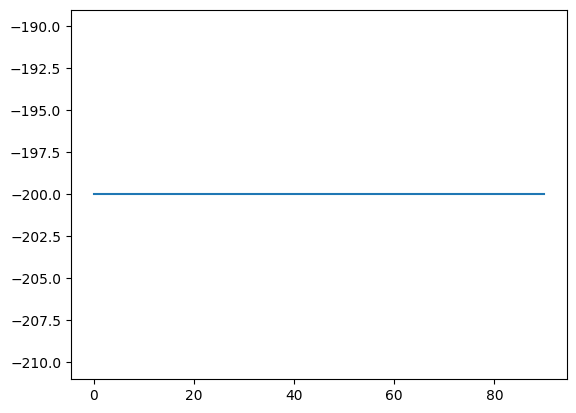

Evaluating the trained agent...
Obtained returns: [-200.0]


In [10]:
# General class for a (random) agent
class RandomAgent:
    def __init__(self, action_space):
        self.action_space = action_space
    
    def act(self, state):
        return self.action_space.sample()
    
    def train(self, state, action, reward, next_state, terminated):
        pass
    

env = gymnasium.make("MountainCar-v0")
agent = RandomAgent(env.action_space)

# Training loop (the agent trains for the duration of hundred episodes)
print("Training the agent...")
total_returns = []
for _ in range(100):
    observation, _ = env.reset()   
    done = False
    R = 0. # Cummulative reward (otherwise known as return) - just for logging purposes
    
    while not done:
        action = agent.act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        agent.train(state, action, reward, next_state, terminated)
        
        state = next_state
        done = terminated or truncated
        R += reward
        
    total_returns.append(R)

# Let's show a plot of the learning progression
plt.plot(utils.moving_average(total_returns, 10))
plt.show()

# Evaluation
print("Evaluating the trained agent...")

# We pass only the name of the environment (and eventual arguments), not the environment itself, because we don't want to render
# anything during the training, but we want to do so during the test phase. This we achieve by creating a new environment
# for the testing / simulation with properly set render_mode argument (which we do inside the simulate function).
print("Obtained returns:", utils.simulate(agent, "MountainCar-v0", steps=200, episodes=1))

env.close()

## Úkol na cvičení

Zkuste si místo náhodného agenta naprogramovat třídu agenta, který se učí chovat v prostředí MountainCar pomocí Q-učení. Dejte pozor na to, že prostředí vrací jako stav spojité hodnoty, takže je třeba si z nich nějak udělat prostředí diskrétní (tedy s konečným množstvím stavů).

Níže je návrh obrysů takového agenta, který můžete případně použít.

In [11]:
class QAgent:
    def __init__(self, action_space, epsilon, alpha, gamma):
        self.action_space = action_space
        
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        
        self.greedy = False
        
        ... # TODO
        
        
    def _discretize(self, state):
        ... # TODO
    
    
    def act(self, state):
        state = self._discretize(state)
        
        if not self.greedy and np.random.random() < self.epsilon:
            chosen_action = self.action_space.sample()
        
        else:
            chosen_action = ... # TODO
            
        return chosen_action
        
        
    def train(self, state, action, reward, next_state, terminated):
        ... # TODO

In [ ]:
env = gymnasium.make("MountainCar-v0")
agent = QAgent(env.action_space, epsilon=..., alpha=..., gamma=...)

# Training
print("Training the agent...")
agent.greedy = False

total_returns = []
for _ in range(1000):
    state, _ = env.reset()
    done = False
    R = 0. # return
    
    while not done:
        action = agent.act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        agent.train(state, action, reward, next_state, terminated)
        
        state = next_state
        done = terminated or truncated
        R += reward
        
    total_returns.append(R)

env.close()

plt.plot(utils.moving_average(total_returns, 10))
plt.show()

# Evaluation
print("Evaluating the trained agent...")
agent.greedy = True
print("Obtained returns:", utils.simulate(agent, "MountainCar-v0", steps=200, episodes=3))